# Experiment description
## Hypothesis: 
The amount of predictability of agressive behavior occurrence is bigger for an specific time period. 
## Method: 
Use of predictability and complementary measures such as constancy and contingency.
## Periods: 
- Trimester (by days) between 2017-2018
- Month (by days) between 2017-2018
- Week (by days) between 2017-2018

TODO (currently limited by dataset size):
- Year (by days)
- Semester (by days)

## Built-in methods

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
import scipy
import math
from math import pi
%matplotlib inline

In [2]:
# https://plot.ly/python/v3/fft-filters/
def low_pass_filter(signal_values, fc =0.04, b =0.08):
    N = int(np.ceil((4 / b)))
    if not N % 2: N += 1
    n = np.arange(N)

    sinc_func = np.sinc(2 * fc * (n - (N - 1) / 2.))
    window = 0.42 - 0.5 * np.cos(2 * np.pi * n / (N - 1)) + 0.08 * np.cos(4 * np.pi * n / (N - 1))
    sinc_func = sinc_func * window
    sinc_func = sinc_func / np.sum(sinc_func)

    s = signal_values
    s = s - np.nanmean(s)
    filtered_signal = np.convolve(s, sinc_func)
    return filtered_signal

In [3]:
# Methods for slicing windows
def im2patches(im,n):
    patches = [];
    for i in range(len(im)-n):
        patch = im[i:(i+n-1)]        
        patch = patch - np.nanmean(patch);
        if(np.linalg.norm(patch)>0):
            patch = patch/np.linalg.norm(patch);
        if i==0:
            patches = patch;
        else:
            patches = np.vstack((patches,patch))
    return patches;


def writeEmbeding(timeSeries,lenWindow,samplePath):
    slicingWindows = im2patches(timeSeries,lenWindow);
    workingPath = '/Users/anamaria/Desktop/dev/security_project/periodicity_experiments/predictibility/slicing/'
    prevStation = str(samplePath);
    with open(workingPath+'slicingWindows'+"_"+str(prevStation)+"_"+str(lenWindow)+'_.pickle', 'wb') as f:
        lv = slicingWindows.tolist();                        
        pickle.dump(lv, f, protocol=2)

    workingPath = '/Users/anamaria/Desktop/dev/security_project/periodicity_experiments/predictibility/timeSeries/'    
    with open(workingPath+'timeSeries'+"_"+str(prevStation)+"_"+str(lenWindow)+'_.pickle', 'wb') as f:
        lv = timeSeries.tolist();                        
        pickle.dump(lv, f, protocol=2)


In [4]:
#Methods for predictibility
def getBarcode(samplePath,lenWindow):
    barcode = [];

    with open(workingPath+'timeSeries/'+'timeSeries_'+samplePath+'_'+str(lenWindow)+'_'+'.pickle', 'rb') as f:
            timeSeries = pickle.load(f);            
    return (barcode,timeSeries);

def computeBarcodeEntropy(barsLenB0):
    barlen = np.array(barsLenB0);
    barlen = barlen/barlen.sum();
    hbc = 0;
    for i in range(barlen.shape[0]):
        if barlen[i]!=0:
            hbc = hbc-(barlen[i])*np.log(barlen[i]);
    return hbc;


def computeGeneralPredictability(timeSeries,binsData,lenWindow):
    # Colwell, R. K. (1974). Predictability, constancy, and contingency of periodic phenomena. Ecology, 55(5), 1148-1153.
    # Normalize the caudal values
    nLevels = binsData.shape[0]-1;
    matStations = np.array(timeSeries).reshape((np.array(timeSeries).shape[0]//lenWindow,lenWindow))    

    grandMean = np.mean(np.mean(matStations));
    #matStations = matStations / grandMean;
    N = np.zeros((nLevels,lenWindow));
    for i in range(1,matStations.shape[1]): 
        # Computes histograms per columns
        hist, bin_edges = np.histogram(matStations[:,i],bins = binsData);
        N[:,i] = hist;
    X = np.sum(N, axis=0);
    Y = np.sum(N, axis=1);
    Z = np.sum(Y);
    hx = 0;
    hy = 0;
    hxy = 0;
    for j in range(X.shape[0]):
        if X[j]!=0:
            hx = hx-(X[j]/Z)*np.log(X[j]/Z);
            
    for i in range(Y.shape[0]):
        if Y[i]!=0:
            hy = hy-(Y[i]/Z)*np.log(Y[i]/Z);
            
    for i in range(Y.shape[0]):
        for j in range(X.shape[0]):
            if N[i,j]!=0:
                hxy = hxy-((N[i,j]/Z)*np.log(N[i,j]/Z));    
    
    # predictability
    p = 1 - (hxy - hx)/np.log(N.shape[0]);
    # constancy
    c = 1 - hy/np.log(N.shape[0]);
    # Returns constancy and contingency
    return (c,p-c,p);


## Load data

In [5]:
data_location = '/Users/anamaria/Desktop/dev/security_project/datasets/verify_enrich_nuse_29112019.csv'
df_input = pd.read_csv(data_location,delimiter=",")

In [6]:
df_input['date']=pd.to_datetime(df_input['FECHA'])
df_by_date = pd.DataFrame(df_input.groupby('date').size(),columns=["total_eventos"])

In [98]:
df_by_date.describe()

,total_eventos
count,761.000000
mean,1061.411301
std,399.153371
min,541.000000
25%,798.000000
50%,892.000000
75%,1260.000000
max,3371.000000


In [101]:
#Levels=[541,1061,3371]
Levels=[798,892,1260]

In [102]:
levelCategories = list(map(lambda x: str(x), Levels))
levelCategories

['798', '892', '1260']

## Filter signal by days (LPF)

In [103]:
df_days_values = pd.Series(df_by_date['total_eventos']).values

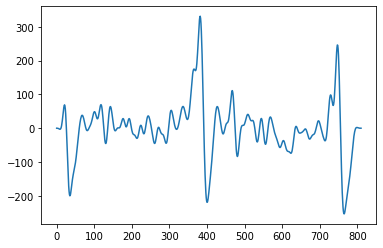

In [104]:
filtered_df_days = low_pass_filter(df_days_values, fc =0.04, b =0.08)
plt.plot(filtered_df_days)

## Time windows

In [105]:
len(filtered_df_days)

811

In [106]:
#Find m.c.m according to defined windows (e.g. 7, 30, 90 => mcm = 630)
lT = 630
filtered_df_days = filtered_df_days[0:630]
len(filtered_df_days)

630

In [107]:
for lenWindow in [7,30,90]:
    print(len(filtered_df_days))
    writeEmbeding(filtered_df_days[0:lT],lenWindow,'aggressiveBehavior')
    # Random time series
    tsmaxe = np.random.uniform(0,1,lT)
    writeEmbeding(tsmaxe,lenWindow,'random')

630
630
630


798
7
798
7
---------------------------------
 
892
7
892
7
---------------------------------
 
1260
7
1260
7
---------------------------------
 
798
30
798
30
---------------------------------
 
892
30
892
30
---------------------------------
 
1260
30
1260
30
---------------------------------
 
798
90


/Users/anamaria/Desktop/dev/security_project/security_venv/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app
/Users/anamaria/Desktop/dev/security_project/security_venv/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


798
90
---------------------------------
 
892
90
892
90
---------------------------------
 
1260
90
1260
90
---------------------------------
 


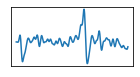

<Figure size 432x288 with 0 Axes>

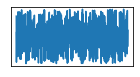

<Figure size 432x288 with 0 Axes>

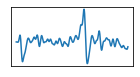

<Figure size 432x288 with 0 Axes>

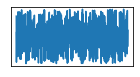

<Figure size 432x288 with 0 Axes>

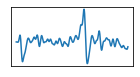

<Figure size 432x288 with 0 Axes>

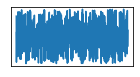

<Figure size 432x288 with 0 Axes>

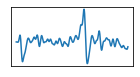

<Figure size 432x288 with 0 Axes>

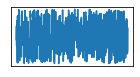

<Figure size 432x288 with 0 Axes>

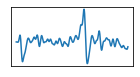

<Figure size 432x288 with 0 Axes>

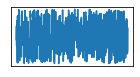

<Figure size 432x288 with 0 Axes>

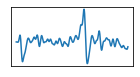

<Figure size 432x288 with 0 Axes>

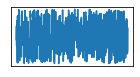

<Figure size 432x288 with 0 Axes>

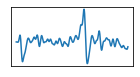

<Figure size 432x288 with 0 Axes>

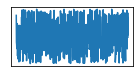

<Figure size 432x288 with 0 Axes>

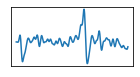

<Figure size 432x288 with 0 Axes>

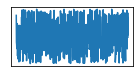

<Figure size 432x288 with 0 Axes>

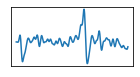

<Figure size 432x288 with 0 Axes>

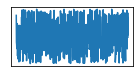

<Figure size 432x288 with 0 Axes>

In [108]:
#find predictibility, constancy and contingency
workingPath = '/Users/anamaria/Desktop/dev/security_project/periodicity_experiments/predictibility/';

flagF = True;
for lenWindow in [7,30,90]:        
    for nLevels in Levels:
        for expName in ['aggressiveBehavior','random']:
            (barcode,timeSeries) = getBarcode(expName,lenWindow);
            binsLevels = np.linspace(np.min(timeSeries),np.max(timeSeries),nLevels);


            ## Characterization for B0
            #print('--------------------------')
            #print('Characterization of '+expName)
            plt.figure(figsize=(2.2,1.1))
            plt.plot(timeSeries)
            plt.xticks([])
            plt.yticks([])
            plt.figure()


            print(nLevels)
            print(lenWindow)

            c,m,p = computeGeneralPredictability(timeSeries,binsLevels,lenWindow)

            if flagF==True:
                flagF = False
                predValues = np.array([expName,lenWindow,nLevels,p,m,c]);
            else:
                predValues = np.vstack((predValues, [expName,lenWindow,nLevels,p,m,c]))


        print('---------------------------------')
        print(' ')


    

In [109]:
predValues

array([['aggressiveBehavior', '7', '798', '0.36136250790145696',
        '0.153716986421934', '0.20764552147952298'],
       ['random', '7', '798', '0.3369821396815206', '0.2123148119931022',
        '0.12466732768841837'],
       ['aggressiveBehavior', '7', '892', '0.36927319608770426',
        '0.156143882049524', '0.21312931403818025'],
       ['random', '7', '892', '0.34559719514041065',
        '0.21496981857172015', '0.1306273765686905'],
       ['aggressiveBehavior', '7', '1260', '0.3911904860317248',
        '0.1687250694000363', '0.2224654166316885'],
       ['random', '7', '1260', '0.37427987975327703',
        '0.21612131596472284', '0.1581585637885542'],
       ['aggressiveBehavior', '30', '798', '0.5531503676817646',
        '0.3500343379065879', '0.20311602977517673'],
       ['random', '30', '798', '0.5466765608007506',
        '0.44228951419195783', '0.10438704660879272'],
       ['aggressiveBehavior', '30', '892', '0.5608201051607771',
        '0.3569246153579163', '0.

In [110]:
df_prediction = pd.DataFrame(predValues, columns=['crime_type','lenWindow','crime_level','predictibility','contingency','constancy'])

In [111]:
df_prediction.head()

,crime_type,lenWindow,crime_level,predictibility,contingency,constancy
0,aggressiveBehavior,7,798,0.36136250790145696,0.153716986421934,0.20764552147952298
1,random,7,798,0.3369821396815206,0.2123148119931022,0.12466732768841837
2,aggressiveBehavior,7,892,0.36927319608770426,0.156143882049524,0.21312931403818025
3,random,7,892,0.34559719514041065,0.21496981857172015,0.1306273765686905
4,aggressiveBehavior,7,1260,0.3911904860317248,0.1687250694000363,0.2224654166316885


In [112]:
df_agressiveBehavior = df_prediction[df_prediction['crime_type']=='aggressiveBehavior']

In [113]:
join=df_agressiveBehavior.pivot('lenWindow','crime_level','predictibility')

In [114]:
var1_order = ['7','30','90']
var2_order = levelCategories
if len(var2_order) > 0:
    join = join.reindex(var2_order, axis=1)
if len(var1_order) > 0:
    join = join.reindex(var1_order)

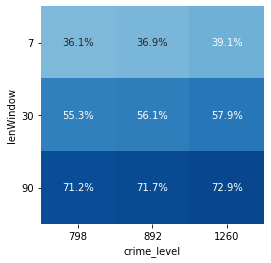

In [115]:
fig, ax = plt.subplots(1,1,sharex=True, sharey=True)
fig.set_size_inches(4, 4)
g=sns.heatmap(join.astype('float'),vmin=0, vmax=0.8,annot=True,fmt=".1%",linewidths=0,cmap="Blues",cbar=False)
g.set_yticklabels(g.get_yticklabels(), rotation = 0)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()